In [25]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

# Reading the CSV file with semicolon as the delimiter
data = pd.read_csv('DataCapstone.csv', delimiter=';')

# Display the first five and the last five rows with centered text styling
from IPython.display import display
# Selecting the first five rows
first_five = data.head()
# Selecting the last five rows
last_five = data.tail()

# Displaying using a single call to display() for aesthetics
display(pd.concat([first_five, last_five]).style.set_table_styles([
    {'selector': 'th, td', 'props': [('text-align', 'center')]},  # Centering text for both headers and data cells
    {'selector': 'th', 'props': [('font-size', '12pt'), ('background-color', 'gray'), ('color', 'white')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('margin', '0 auto'), ('width', '80%')]},
    {'selector': 'td, th', 'props': [('border', '1px solid black')]}
]))

,Date,S&P 500 PRICE IN USD,GOLD PRICE IN USD,BITCOIN PRICE IN USD,ETHEREUM PRICE IN USD
0,01/01/2019,"2506,85","1281,34","3823,44","141,18"
1,02/01/2019,"2510,03","1287,08","3885,87","158,10"
2,03/01/2019,"2447,89","1289,10","3787,81","151,01"
3,04/01/2019,"2531,94","1282,97","3817,71","156,19"
4,07/01/2019,"2549,69","1288,24","4005,45","151,46"
1371,03/04/2024,"5211,49","2282,97","65988,00","3319,70"
1372,04/04/2024,"5147,21","2292,47","68538,00","3330,44"
1373,05/04/2024,"5204,34","2323,04","67857,00","3326,04"
1374,08/04/2024,"5202,39","2330,31","71613,00","3696,86"
1375,09/04/2024,"5209,91","2346,17","69135,00","3504,26"


Training samples: (1052, 60, 4), Test samples: (264, 60, 4)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 60, 50)            11000     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_18 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 102       
                                                                 
Total params: 31,302
Trainable params: 31,302
Non-trainable params: 0
________________________________________________________

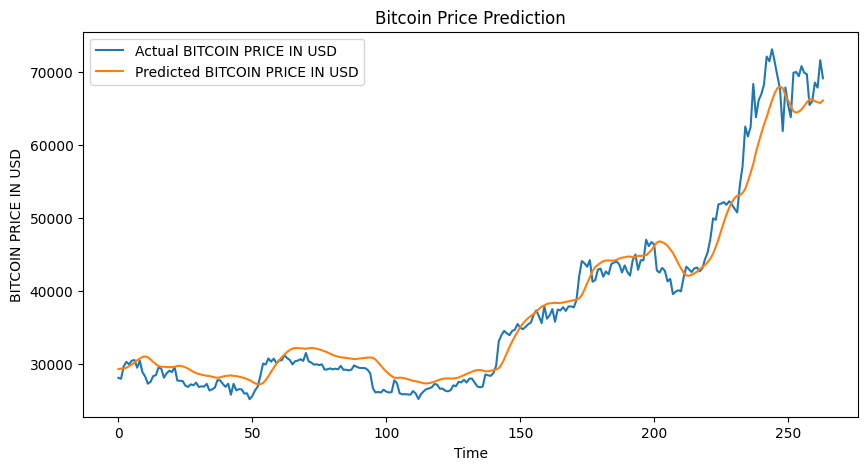

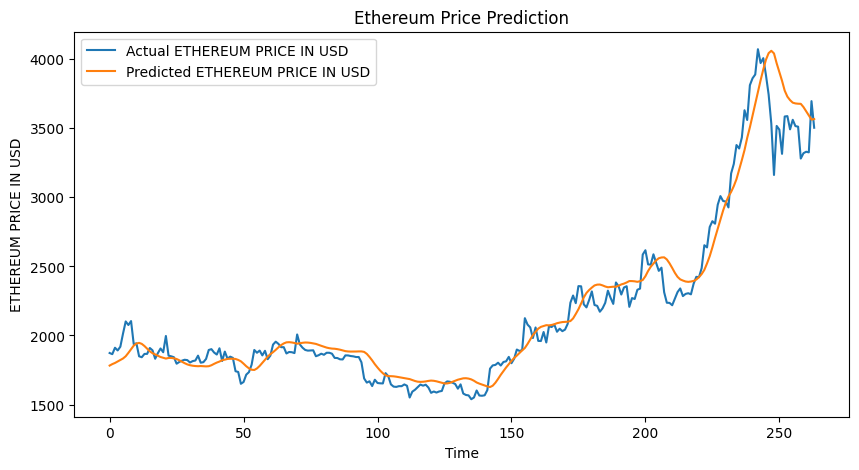

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(DataCapstone[features])

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum prices as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(2)  # Predict Bitcoin and Ethereum prices only
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

# Compare predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 0], label='Actual BITCOIN PRICE IN USD')
plt.plot(predictions_inv[:, 0], label='Predicted BITCOIN PRICE IN USD')
plt.legend()
plt.xlabel('Time')
plt.ylabel('BITCOIN PRICE IN USD')
plt.title('Bitcoin Price Prediction')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 1], label='Actual ETHEREUM PRICE IN USD')
plt.plot(predictions_inv[:, 1], label='Predicted ETHEREUM PRICE IN USD')
plt.legend()
plt.xlabel('Time')
plt.ylabel('ETHEREUM PRICE IN USD')
plt.title('Ethereum Price Prediction')
plt.show()

In [17]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, predictions_inv)
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 3296632.927754775
Mean Absolute Error: 1030.3256279027564
R-squared Score: 0.9534001052141712


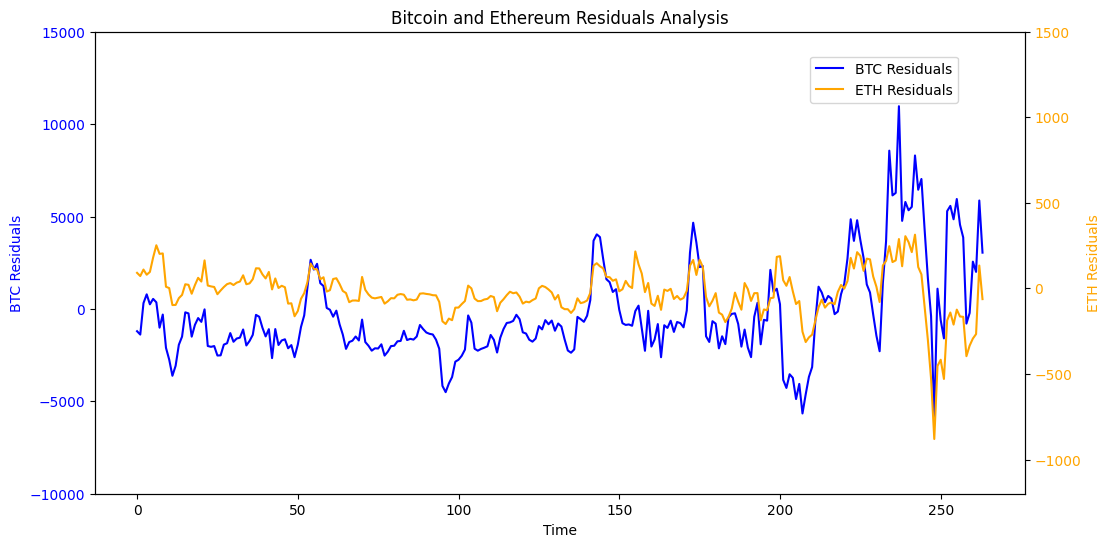

In [18]:
# Calculate residuals
residuals_btc = y_test_inv[:, 0] - predictions_inv[:, 0]
residuals_eth = y_test_inv[:, 1] - predictions_inv[:, 1]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Bitcoin residuals on the primary y-axis
ax1.plot(residuals_btc, label='BTC Residuals', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('BTC Residuals', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Set y-limits for Bitcoin residuals
ax1.set_ylim(-10000, 15000)

# Create a secondary y-axis and plot Ethereum residuals
ax2 = ax1.twinx()
ax2.plot(residuals_eth, label='ETH Residuals', color='orange')
ax2.set_ylabel('ETH Residuals', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set y-limits for Ethereum residuals
ax2.set_ylim(-1200, 1500)

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

# Add title
plt.title('Bitcoin and Ethereum Residuals Analysis')

# Show plot
plt.show()

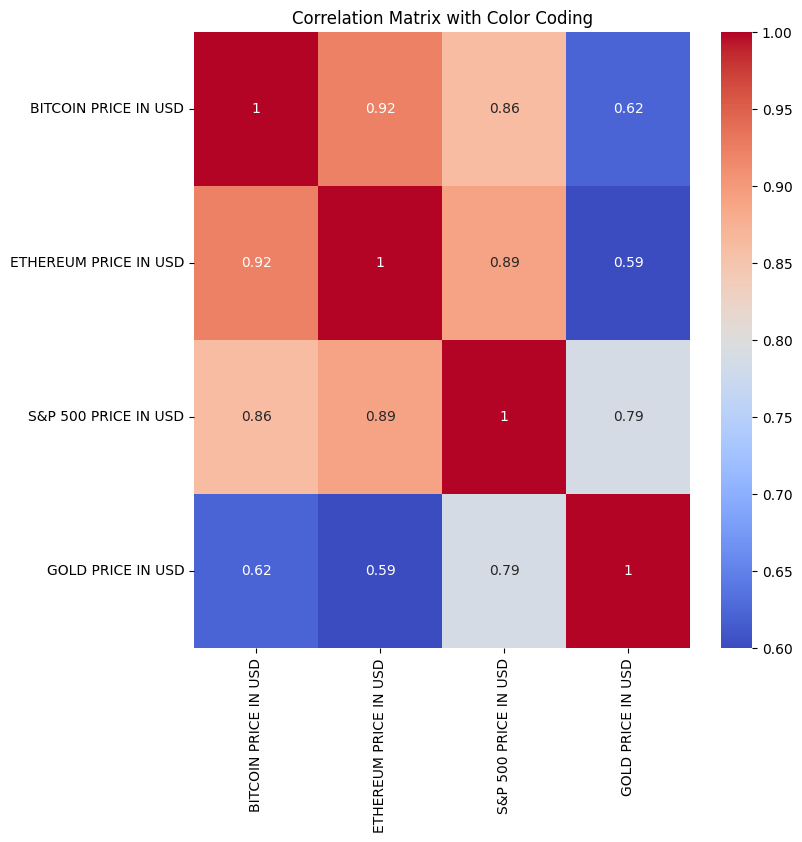

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame named 'DataCapstone'
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Convert the 'Date' column to datetime if applicable and set it as the index
DataCapstone['Date'] = pd.to_datetime(DataCapstone['Date'], dayfirst=True)
DataCapstone.set_index('Date', inplace=True)

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Visualize Correlation Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0.6, vmax=1)
plt.title("Correlation Matrix with Color Coding")
plt.show()

Training samples: (1052, 60, 4), Test samples: (264, 60, 4)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            17664     
                                                                 
 dropout_2 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,818
Trainable params: 50,818
Non-trainable params: 0
________________________________________________________

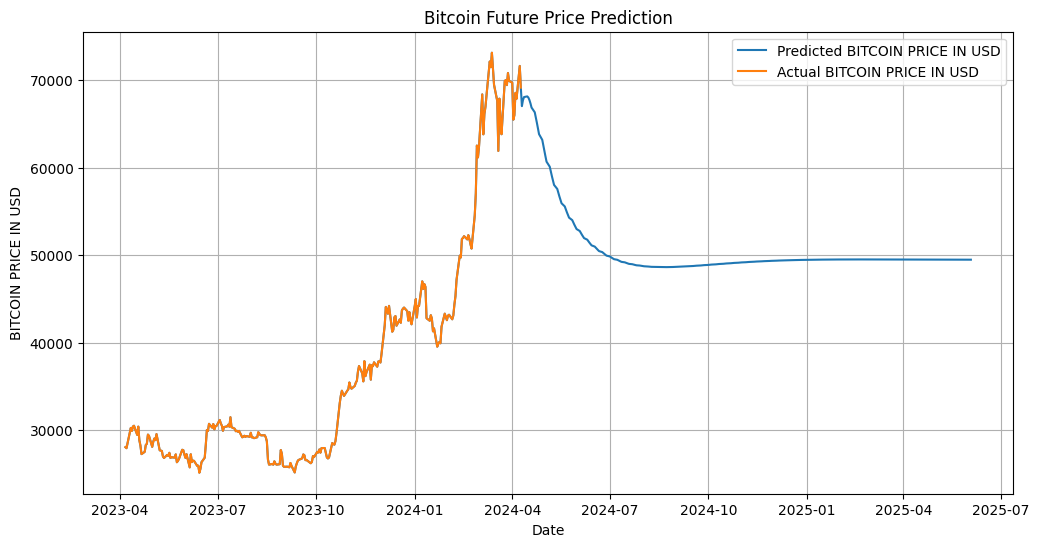

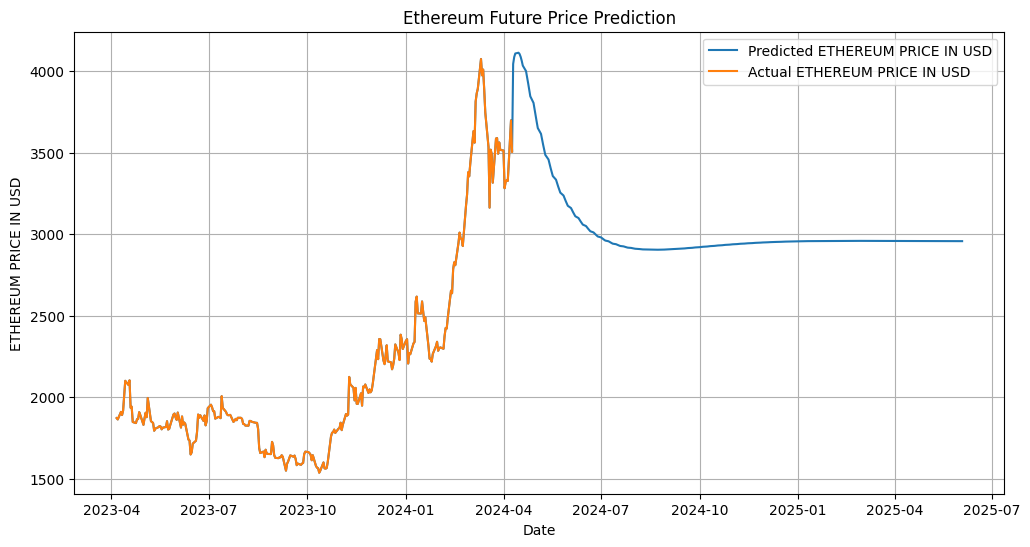

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(DataCapstone[features])

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum prices as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(2)  # Predict Bitcoin and Ethereum prices only
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

# Function to predict future data
def predict_future(model, last_sequence, n_future, btc_eth_corr=0.92):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        full_prediction = np.concatenate([prediction, np.zeros((1, len(features) - 2))], axis=1)
        future_predictions.append(prediction[0])
        current_sequence = np.vstack([current_sequence[1:], full_prediction])
    
    future_predictions = np.array(future_predictions)

    # Adjust Ethereum prices based on the correlation with Bitcoin
    future_predictions[:, 1] = btc_eth_corr * future_predictions[:, 0]
    future_predictions[:, 1] = np.maximum(future_predictions[:, 1], 0)  # Ensure no negative Ethereum prices

    return future_predictions

# Predict the next 300 future values
last_sequence = x_test[-1]
n_future = 300
future_predictions = predict_future(model, last_sequence, n_future)

# Inverse transform predictions to the original scale
future_predictions_inv = scaler.inverse_transform(np.concatenate([future_predictions, np.zeros((len(future_predictions), len(features) - 2))], axis=1))[:, :2]

# Generate date range for future predictions
last_date = DataCapstone.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='B')[1:]  # Use business days

# Combine historical and future data for Bitcoin predictions
bitcoin_full_dates = np.concatenate([DataCapstone.index[-len(y_test_inv):], future_dates])
bitcoin_full_predictions = np.concatenate([y_test_inv[:, 0], future_predictions_inv[:, 0]])

# Combine historical and future data for Ethereum predictions
ethereum_full_dates = np.concatenate([DataCapstone.index[-len(y_test_inv):], future_dates])
ethereum_full_predictions = np.concatenate([y_test_inv[:, 1], future_predictions_inv[:, 1]])

# Plot future predictions vs historical data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_full_dates, bitcoin_full_predictions, label='Predicted BITCOIN PRICE IN USD')
plt.plot(DataCapstone.index[-len(y_test_inv):], y_test_inv[:, 0], label='Actual BITCOIN PRICE IN USD')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BITCOIN PRICE IN USD')
plt.title('Bitcoin Future Price Prediction')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(ethereum_full_dates, ethereum_full_predictions, label='Predicted ETHEREUM PRICE IN USD')
plt.plot(DataCapstone.index[-len(y_test_inv):], y_test_inv[:, 1], label='Actual ETHEREUM PRICE IN USD')
plt.legend()
plt.xlabel('Date')
plt.ylabel('ETHEREUM PRICE IN USD')
plt.title('Ethereum Future Price Prediction')
plt.grid()
plt.show()

In [21]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, predictions_inv)
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 3413559.2925958545
Mean Absolute Error: 893.9469876401929
R-squared Score: 0.9554437767769826
